# Cardiovascular Disease Prediction

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from joblib import Parallel, delayed

## Data Loading

In [2]:
df = pd.read_csv('datasets\cardio_train.csv', sep=';')
print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


### Features:
    Age | Objective Feature | age | int (days)
    Height | Objective Feature | height | int (cm) |
    Weight | Objective Feature | weight | float (kg) |
    Gender | Objective Feature | gender | categorical code |
    Systolic blood pressure | Examination Feature | ap_hi | int |
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    Smoking | Subjective Feature | smoke | binary |
    Alcohol intake | Subjective Feature | alco | binary |
    Physical activity | Subjective Feature | active | binary |
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


## Data Cleaning and Preprocessing (missing values, duplicates, outliers, anomalies)


In [3]:
#Cramers Function

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.

        uses correction from Bergsma and Wicher,

        Journal of the Korean Statistical Society 42 (2013): 323-328

    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [4]:
df['age'] = round(df['age']/365.25)
df['age'] = df['age'].astype(int)

In [5]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [6]:
print(df.describe().T)

               count          mean           std    min       25%      50%  \
id           70000.0  49972.419900  28851.302323    0.0  25006.75  50001.5   
age          70000.0     53.303157      6.760171   30.0     48.00     54.0   
gender       70000.0      1.349571      0.476838    1.0      1.00      1.0   
height       70000.0    164.359229      8.210126   55.0    159.00    165.0   
weight       70000.0     74.205690     14.395757   10.0     65.00     72.0   
ap_hi        70000.0    128.817286    154.011419 -150.0    120.00    120.0   
ap_lo        70000.0     96.630414    188.472530  -70.0     80.00     80.0   
cholesterol  70000.0      1.366871      0.680250    1.0      1.00      1.0   
gluc         70000.0      1.226457      0.572270    1.0      1.00      1.0   
smoke        70000.0      0.088129      0.283484    0.0      0.00      0.0   
alco         70000.0      0.053771      0.225568    0.0      0.00      0.0   
active       70000.0      0.803729      0.397179    0.0      1.0

In [7]:
# checking for anomalies cholesterol(1-3),  glucose(1-3), alco(0-1), active(0-1), cardio(0-1)
df.nunique()

id             70000
age               28
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int32  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int32(1), int64(11)
memory usage: 6.7 MB


In [9]:
df.shape

(70000, 13)

In [10]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [11]:
df.head()
for col in df.columns:
    print(df[col].unique())

[    0     1     2 ... 99996 99998 99999]
[50 55 52 48 60 61 62 54 40 46 58 59 63 64 45 57 56 49 51 44 65 53 47 42
 39 43 41 30]
[2 1]
[168 156 165 169 151 157 178 158 164 173 181 172 170 154 162 163 153 159
 166 155 160 175 171 152 187 148 179 180 188 185 167 183 174 176 161 184
 177 182  76 149 142 150 144 147 186 146 141 195 140 198 145 143 196 138
 194 190 134 136 100 120 189 137 192 122 250 191 117  70  97 119 130 110
 193  75 132  71 135  67 125 139 133  74  98 112 207  68  55  81  80  64
  91  60 109  72 197  65 128 105 108 200 104 111 113  96 131  59  66  99
  57]
[ 62.    85.    64.    82.    56.    67.    93.    95.    71.    68.
  80.    60.    78.   112.    75.    52.    83.    69.    90.    45.
  65.    59.    66.    74.   105.    73.    55.    70.    72.    63.
  50.   107.    84.    77.    79.    76.    58.   115.    97.    53.
  57.    49.   110.    94.    92.    87.   103.    88.    99.   100.
  61.    48.    54.    51.    47.    91.   104.    81.    98.   108.
  89.  

In [12]:
columns = df.columns
categorical_columns = []
continuous_columns = ['cardio']
for col in columns:
    if col != 'cardio':
        if df[col].nunique() <= 10:
            categorical_columns.append(col)
        else:
            continuous_columns.append(col)

print("Categorical Columns: ", categorical_columns)
print("Continuous Columns: ", continuous_columns)


Categorical Columns:  ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
Continuous Columns:  ['cardio', 'id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo']


In [13]:
for i in categorical_columns:
    print(i)
    matrix = pd.crosstab(df[i], df['cardio']).to_numpy()
    print((cramers_corrected_stat(matrix)))

gender
0.007140984138192398
cholesterol
0.22108459105726172
gluc
0.09141116970410079
smoke
0.014965735354595095
alco
0.006206645866171115
active
0.03541641750397704


In [14]:
for i in continuous_columns:
    print(i)
    lr = LogisticRegression()
    lr.fit(np.expand_dims(df[i], axis=1), df['cardio'])
    print(lr.score(np.expand_dims(df[i], axis=1), df['cardio']))

cardio
1.0
id
0.4997142857142857
age
0.5959428571428571
height
0.5063285714285715
weight
0.5760571428571428
ap_hi
0.7135571428571429
ap_lo
0.5580714285714286


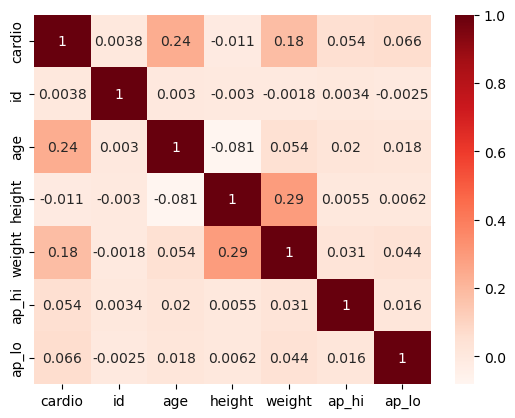

In [15]:
# Finding the corelation between continuous data 
df_con = df.loc[:, continuous_columns]
corr = df_con.corr()
df_con.corr()['cardio'].sort_values()
plt.figure()
sns.heatmap(corr, cmap='Reds', annot=True)
plt.show()


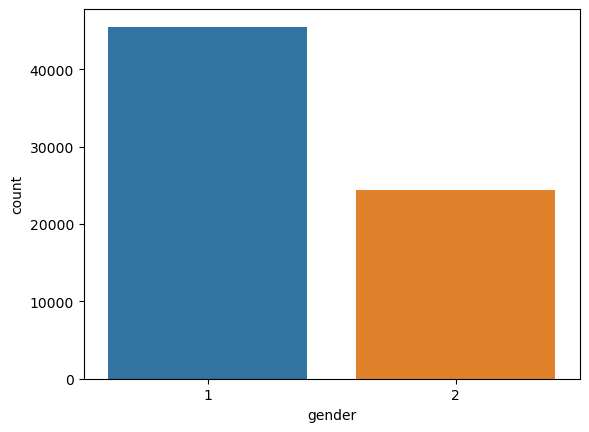

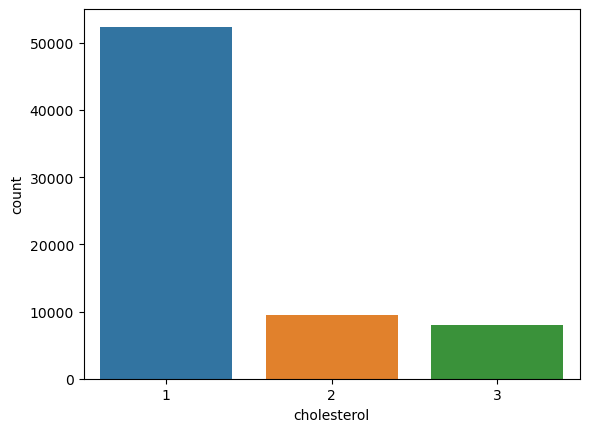

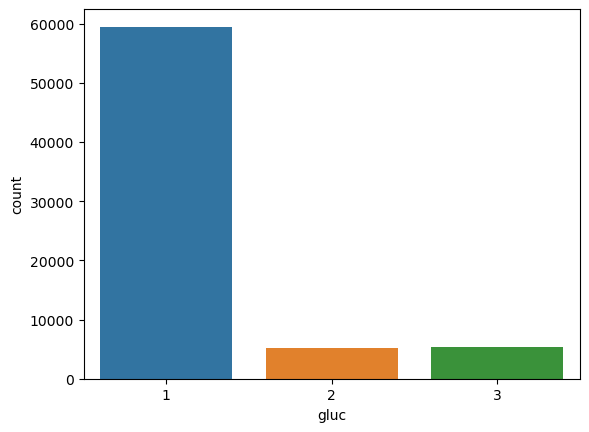

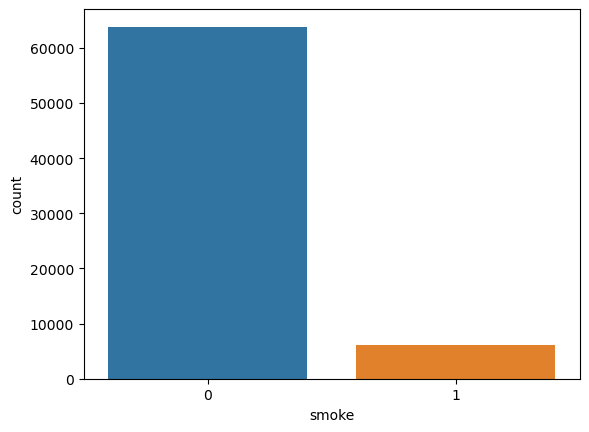

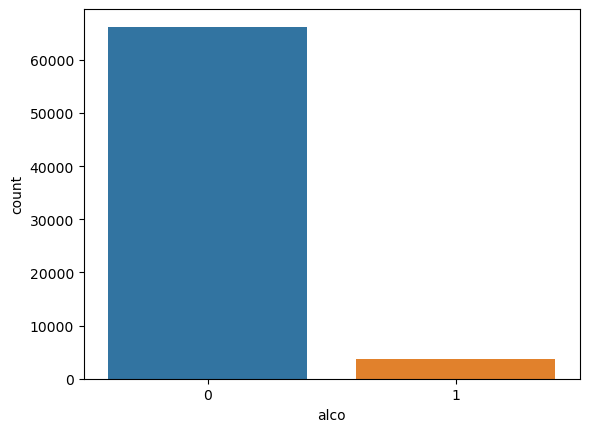

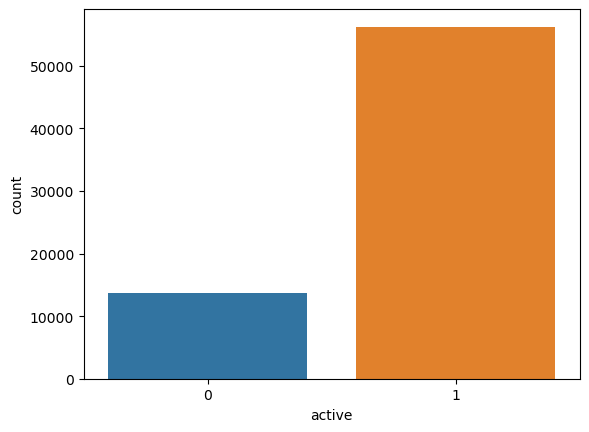

In [16]:
palettes = ["deep", "muted", "pastel", "bright", "dark"]

for i, x in enumerate(categorical_columns):
    sns.color_palette("husl", 8)
    sns.countplot(data=df, x=x)
    plt.xlabel(x)
    plt.show()

## Model Selection and Training

In [17]:
X_train = df.drop(labels = "cardio", axis = 1)
y_train = df["cardio"]
y_train

0        0
1        1
2        1
3        1
4        0
        ..
69995    0
69996    1
69997    1
69998    1
69999    0
Name: cardio, Length: 70000, dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2 , random_state= 42, stratify=y_train)

In [19]:
# Logistic Regression Pipeling
pipeline_mms_lr = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('logistic_regression', LogisticRegression())
])

pipeline_ss_lr = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

# Random Forest
pipeline_mms_rf = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('random_forest', RandomForestClassifier())
])

pipeline_ss_rf = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier())
])

# Gradient Boost
pipeline_mms_gb = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('gradient_boost', GradientBoostingClassifier())
])

pipeline_ss_gb = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('gradient_boost', GradientBoostingClassifier())
])


# SVC
pipeline_mms_svc = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('svc', SVC())
])

pipeline_ss_svc = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('svc', SVC())
])

In [20]:
pipelines = [pipeline_mms_lr, pipeline_ss_lr,
            pipeline_mms_rf, pipeline_ss_rf
            # pipeline_mms_gb, pipeline_ss_gb,
            # pipeline_mms_svc, pipeline_ss_svc
            ]

In [21]:
pipe_dict = {}
best_score = 0
# Key for the dictionary
model_name = ['MMS + Logistic Regression', 'SS + Logistic Regression', 
              'MMS + Random Forest', 'SS + Random Forest' 
            #   'MMS + Gradient Boost', 'SS + Gradient Boost', 
            #   'MMS + SVC', 'SS + SVC'
              ]

In [24]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [25]:
# Model Evaluation

for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    # key is mode_name, values are accuracy score and f1 score
    pipe_dict[model_name[i]] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]

    # To get the best score from each model
    if model.score(X_test, y_test) > best_score:
        best_score = model.score(X_test, y_test)
        best_pipeline = model_name[i]

In [26]:
print('The best model for heart attack prediction is {} with the accuracy score of {}'.format(best_pipeline, best_score))

The best model for heart attack prediction is MMS + Random Forest with the accuracy score of 0.7187142857142857


In [27]:
print(pipe_dict)

{'MMS + Logistic Regression': [0.6443571428571429, 0.644013484389997], 'SS + Logistic Regression': [0.7131428571428572, 0.7126929768690589], 'MMS + Random Forest': [0.7187142857142857, 0.7185868039650742], 'SS + Random Forest': [0.7165, 0.716387385680264]}


In [28]:
# Converting pipe into DataFrame    
model_comparison_df = pd.DataFrame.from_dict(pipe_dict).T
model_comparison_df.columns = ['Accuracy_score', 'f1_score']
model_comparison_df.sort_values(['Accuracy_score', 'f1_score'], ascending = False, inplace=True)
model_comparison_df.style.background_gradient(cmap='GnBu')

,Accuracy_score,f1_score
MMS + Random Forest,0.718714,0.718587
SS + Random Forest,0.716500,0.716387
SS + Logistic Regression,0.713143,0.712693
MMS + Logistic Regression,0.644357,0.644013
